### Cluster-wise Feature Composition Analysis

This script explores how biological features vary across clusters using either `all_data_cluster.csv` or `pca_data_clustered.csv`. It handles both **categorical** and **continuous** features.

- **ANOVA + eta squared** is used for continuous features.  
- **Chi-square + Cramér's V** is used for categorical features.

> Due to large sample size, many features showed significant *p*-values. To assess **practical significance**, eta squared and Cramér’s V were used as effect size measures.  
> - Eta squared: variance explained by clusters.  
> - Cramér’s V: strength of association for categorical features.

The script also visualizes feature distributions across clusters.

#### Summary of Observations

- **Categorical features** like `Host`, `Class`, `Phylum`, `Kingdom`, `Realm`, and `Order` show strong compositional differences.
- **Continuous features** such as `molGC (%)`, `Number CDS`, `Genome Length (bp)`, `Coding Capacity (%)`, and `tRNAs` vary significantly between clusters.
- The most prominent signals came from **GC content** and **host taxonomy**, supporting that **k-mer profiles capture biologically meaningful patterns**, particularly related to viral host preference.


In [73]:
# load metadata 
import pandas as pd

all_clustered_df = pd.read_csv('../data/all_data_clustered.csv')
# pca_clustered_df = pd.read_csv('../data/pca_data_clustered.csv')


In [74]:
# merge with metadata

meta_data = pd.read_csv('../data/filtered_meta_data.csv')

meta_data['cluster_label'] = all_clustered_df['#cluster_label']
all_meta_data = meta_data.copy()


In [75]:
# checking columns
all_meta_data.columns

Index(['Accession', 'Description', 'Classification', 'Genome Length (bp)',
       'molGC (%)', 'Molecule', 'Number CDS', 'Positive Strand (%)',
       'Negative Strand (%)', 'Coding Capacity(%)', 'tRNAs', 'Host',
       'Lowest Taxa', 'Genus', 'Sub-family', 'Family', 'Order', 'Class',
       'Phylum', 'Kingdom', 'Realm', 'Baltimore Group', 'cluster_label'],
      dtype='object')

In [76]:
# Drop ID-like or low-variation columns

all_meta_data = all_meta_data.drop(columns=['Accession', 'Description', 'Classification',
                                            'Sub-family', 'Molecule', 'Lowest Taxa'])

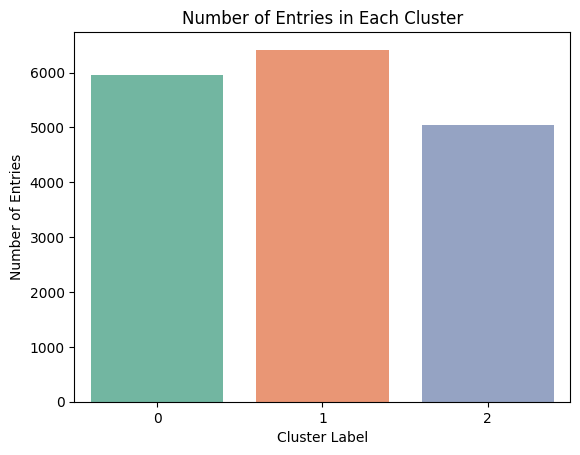

In [77]:
# Plot the number of entries in each cluster
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a color palette with as many colors as clusters
palette = sns.color_palette("Set2", all_meta_data['cluster_label'].nunique())

sns.countplot(data=all_meta_data, x='cluster_label', hue = 'cluster_label',legend=False, order=sorted(all_meta_data['cluster_label'].unique()), palette=palette)

plt.xlabel('Cluster Label')
plt.ylabel('Number of Entries')
plt.title('Number of Entries in Each Cluster')
plt.show()



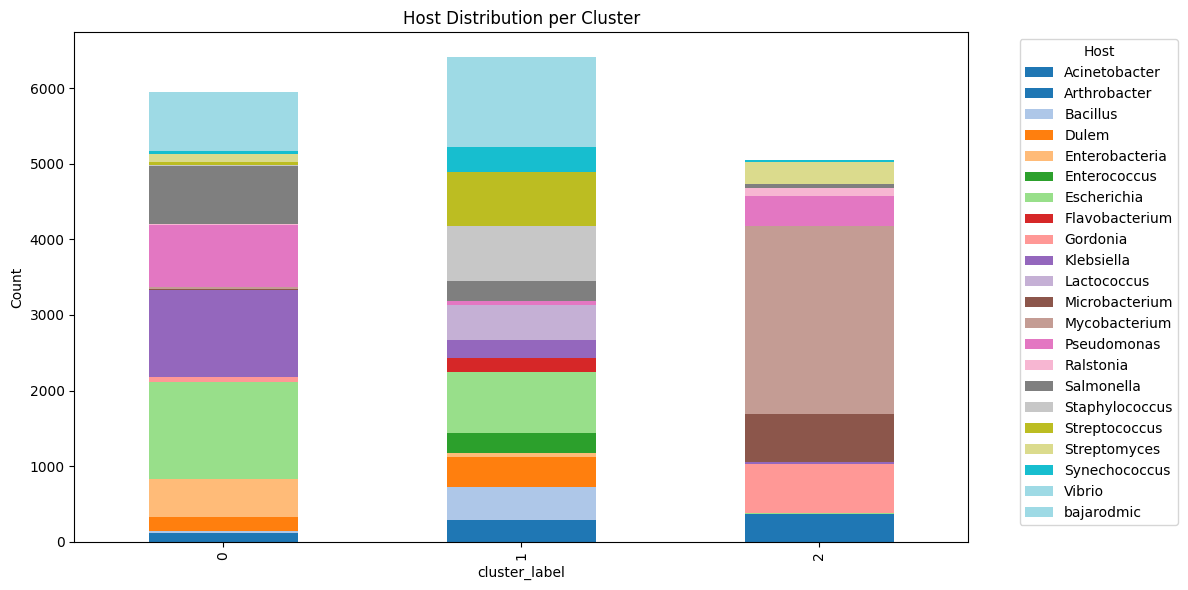

In [78]:
# Visualize how host types are distributed across clusters
host_cluster_counts = all_meta_data.groupby(['cluster_label', 'Host']).size().unstack(fill_value=0)

host_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.ylabel('Count')
plt.title('Host Distribution per Cluster')
plt.legend(title='Host', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Statistical Comparison of Categorical Features Across Clusters


In [79]:

# cat_cols = ['kmer_6','Host', 'Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'Realm', 'Baltimore Group']
cat_cols = ['Accession', 'Description', 'Classification', 'Host',
       'Lowest Taxa', 'Genus', 'Sub-family', 'Family', 'Order', 'Class',
       'Phylum', 'Kingdom', 'Realm', 'Baltimore Group']


# Keep features with a reasonable number of categories (3 to 30)

valid_features = [col for col in cat_cols if 3 <= meta_data[col].nunique() <= 30]
valid_features



['Host', 'Order', 'Class', 'Phylum', 'Kingdom', 'Realm', 'Baltimore Group']

In [59]:
from scipy.stats import chi2_contingency
import numpy as np
# Function to calculate Cramér’s V (with bias correction) and p-value

def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))), p

# Analyze significane for each feature
results = []
for col in valid_features:
    confusion = pd.crosstab(meta_data[col], meta_data['cluster_label'])
    v, p = cramers_v(confusion)
    results.append((col, round(v, 3), p))

results_df = pd.DataFrame(results, columns=["Feature", "CramersV", "P_Value"])
results_df["Strong + Significant"] = (results_df["P_Value"] < 0.05) & (results_df["CramersV"] > 0.2)
results_df.sort_values(by="CramersV", ascending=False, inplace=True)
results_df



,Feature,CramersV,P_Value,Strong + Significant
0,Host,0.780,0.000000e+00,True
2,Class,0.211,0.000000e+00,True
3,Phylum,0.211,0.000000e+00,True
4,Kingdom,0.211,0.000000e+00,True
5,Realm,0.210,0.000000e+00,True
1,Order,0.203,1.685420e-300,True
6,Baltimore Group,0.193,2.065138e-279,False


#### Visualizing Categorical Features with Significant Cluster Differences


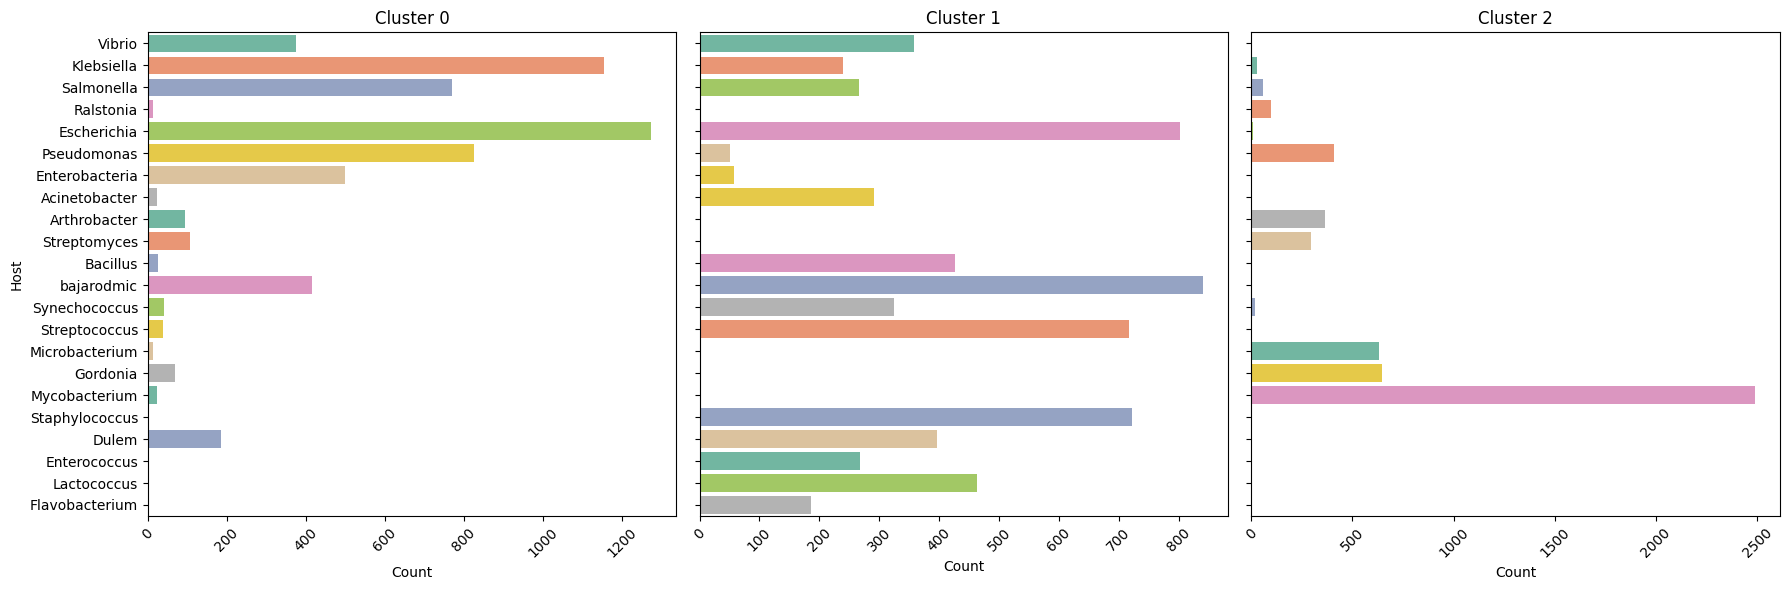

In [27]:
# host distribution across clusters

clusters = sorted(all_meta_data['cluster_label'].unique())
fig, axes = plt.subplots(1, len(clusters), figsize=(18, 6), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axes[i]
    subset = all_meta_data[all_meta_data['cluster_label'] == cluster]
    sns.countplot(data=subset, y='Host', hue='Host', palette='Set2', legend=False, ax=ax)
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('Count')
    
    ax.set_ylabel('Host')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


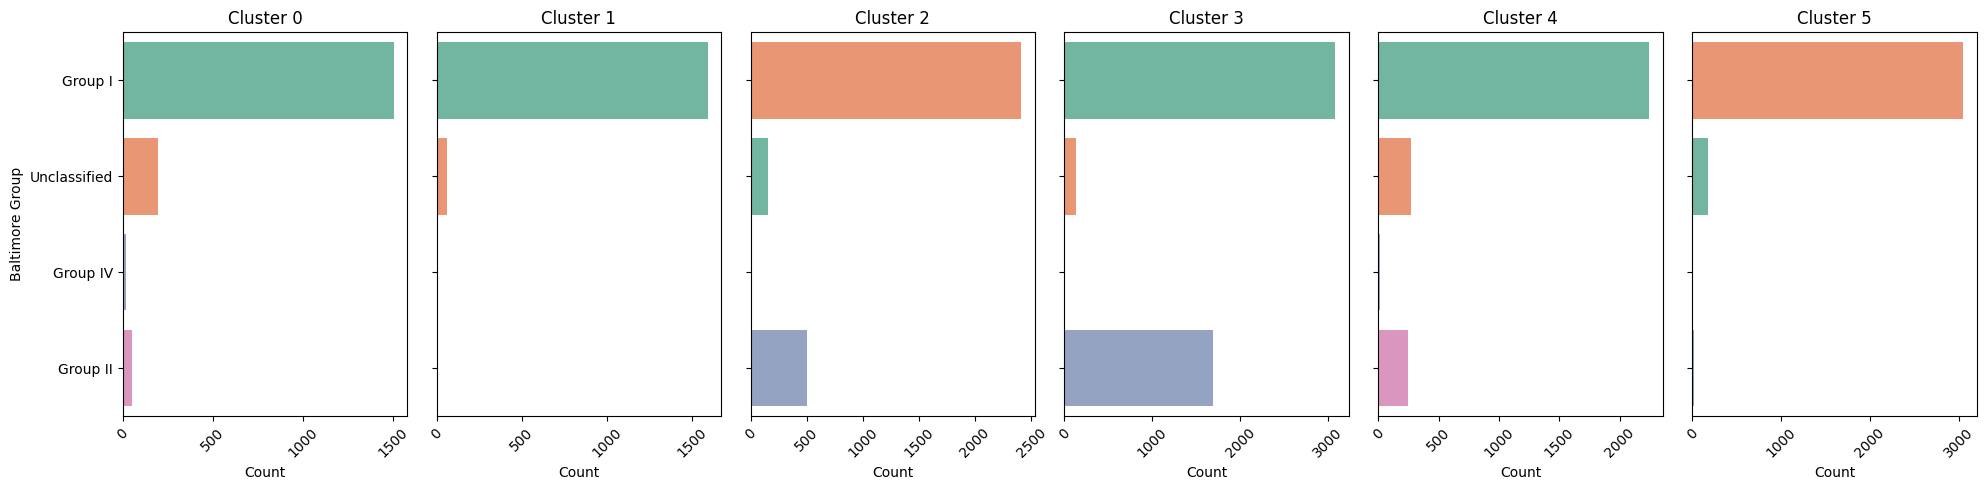

In [158]:
# Baltimore Group distribution across clusters


clusters = sorted(all_meta_data['kmer_6'].unique())
fig, axes = plt.subplots(1, len(clusters), figsize=(20, 5), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axes[i]
    subset = all_meta_data[all_meta_data['kmer_6'] == cluster]
    sns.countplot(data=subset, y='Baltimore Group', hue='Baltimore Group', palette='Set2', legend=False, ax=ax)
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('Count')
    
    ax.set_ylabel('Baltimore Group')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


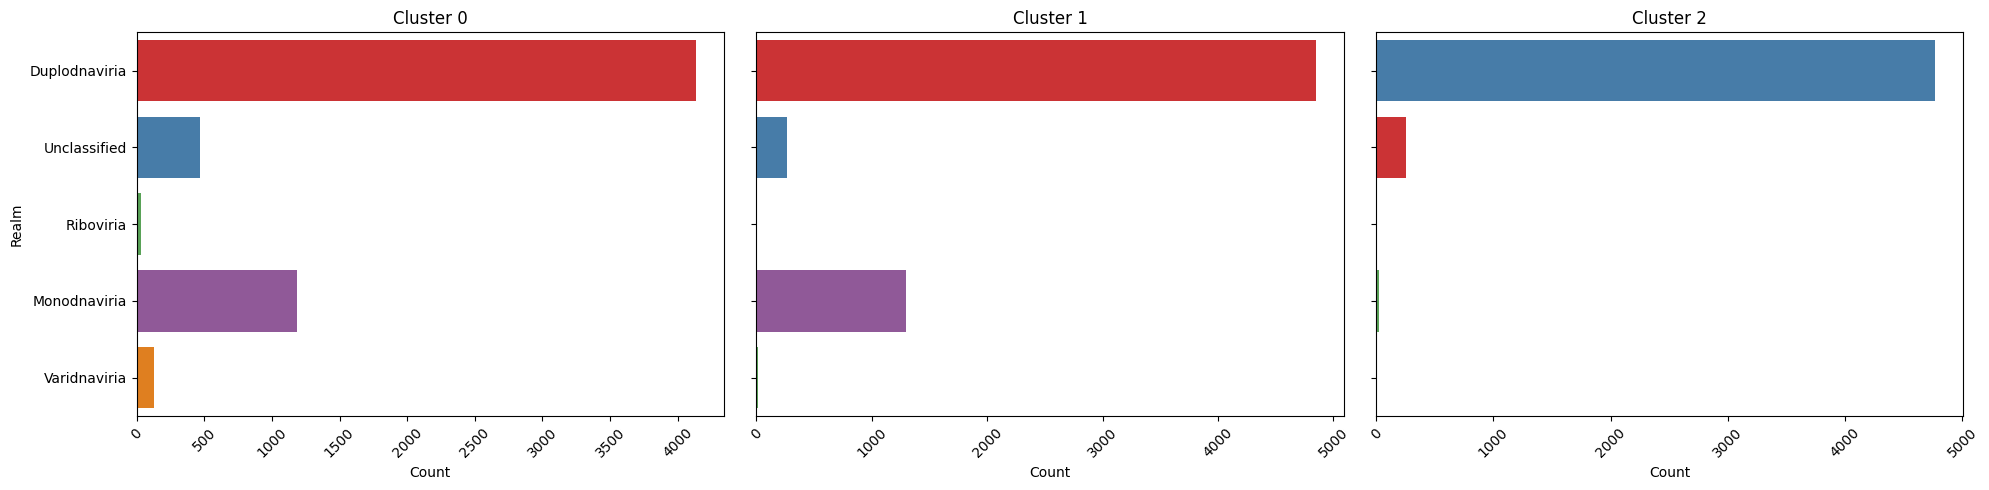

In [62]:
# Realm	distribution across clusters

clusters = sorted(all_meta_data['cluster_label'].unique())
fig, axes = plt.subplots(1, len(clusters), figsize=(20, 5), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axes[i]
    subset = all_meta_data[all_meta_data['cluster_label'] == cluster]
    sns.countplot(data=subset, y='Realm', hue='Realm', palette='Set1', legend=False, ax=ax)
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('Count')
    
    ax.set_ylabel('Realm')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Statistical Comparison of Continuous Features Across Clusters


In [72]:
from scipy.stats import f_oneway   

# List of continuous features
continuous_features = ['Genome Length (bp)', 'molGC (%)', 'Number CDS', 
                       'Positive Strand (%)', 'Negative Strand (%)', 
                       'Coding Capacity(%)', 'tRNAs']

anova_results = []

for feature in continuous_features:
    groups = [group[feature].dropna() for cluster, group in all_meta_data.groupby('cluster_label')]
    
    stat, p_value = f_oneway(*groups)
    all_values = all_meta_data[feature].dropna()
    grand_mean = all_values.mean()
    sst = sum((all_values - grand_mean)**2)
    
    # Between-group sum of squares (SSB)
    ssb = sum([len(g) * (g.mean() - grand_mean)**2 for g in groups])
    
    eta_squared = ssb / sst if sst != 0 else 0
    
    significant = "Yes" if p_value < 0.001 else "No"

    Difference = "Large" if eta_squared > 0.14 else "Small" if eta_squared < 0.06 else "Medium"
    
    anova_results.append((feature, p_value, eta_squared, significant, Difference))

anova_df = pd.DataFrame(anova_results, columns=['Feature', 'p_value', 'Eta Squared', '(p < 0.001)', 'Difference'])
anova_df.sort_values('p_value', inplace=True)

print(anova_df)


               Feature        p_value  Eta Squared (p < 0.001) Difference
1            molGC (%)   0.000000e+00     0.899794         Yes      Large
2           Number CDS  2.506520e-228     0.058391         Yes      Small
0   Genome Length (bp)  5.904771e-196     0.050299         Yes      Small
5   Coding Capacity(%)   2.703177e-87     0.022624         Yes      Small
6                tRNAs   9.658204e-63     0.016260         Yes      Small
3  Positive Strand (%)   4.732994e-02     0.000350          No      Small
4  Negative Strand (%)   4.732994e-02     0.000350          No      Small


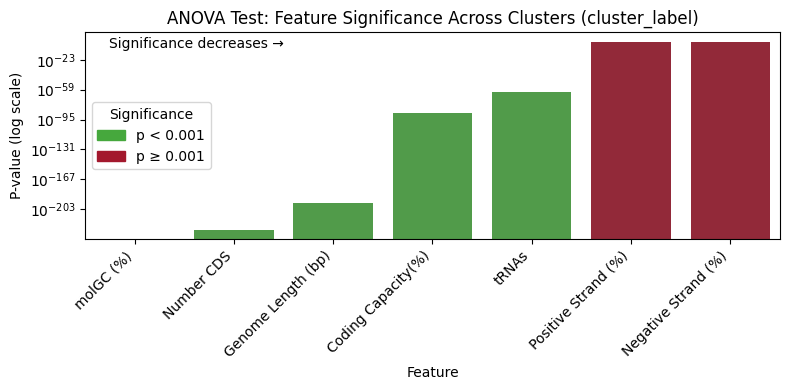

In [82]:

import matplotlib.patches as mpatches
colors = ['#46a83d' if sig == "Yes" else '#a3182d' for sig in anova_df['(p < 0.001)']]


plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Feature', y='p_value', data=anova_df, palette=colors, hue='Feature')

plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel('P-value (log scale)')
plt.title('ANOVA Test: Feature Significance Across Clusters (cluster_label)')

green_patch = mpatches.Patch(color='#46a83d', label='p < 0.001')
red_patch = mpatches.Patch(color='#a3182d', label='p ≥ 0.001')
plt.legend(handles=[green_patch, red_patch], title='Significance')


# Add an arrow showing increasing significance
arrow_y = ax.get_ylim()[1] * 1e-19
# print(arrow_y)
arrow_x_start = 1.5

plt.annotate('Significance decreases →',
             xy=(arrow_x_start, arrow_y),
             ha='right', fontsize=10)

plt.tight_layout()
plt.show()


### Visualizing Continouous Features with Significant Cluster Differences


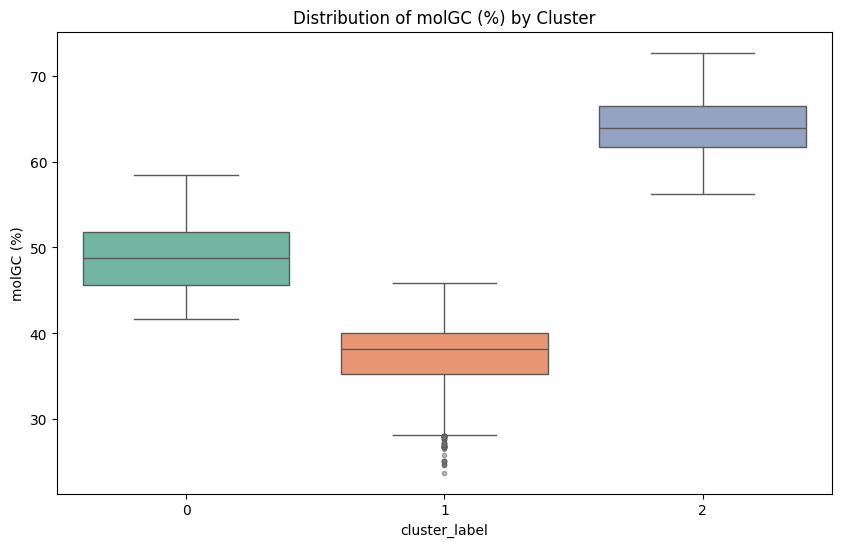

In [83]:

# show comparison for molGC (%) for each group

cus_dots = dict(marker='o', markersize=3, markerfacecolor='gray', alpha=0.5)
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_meta_data, x='cluster_label', y='molGC (%)' , palette='Set2', hue = 'cluster_label',legend=False, flierprops=cus_dots)
plt.title('Distribution of molGC (%) by Cluster')
plt.show()


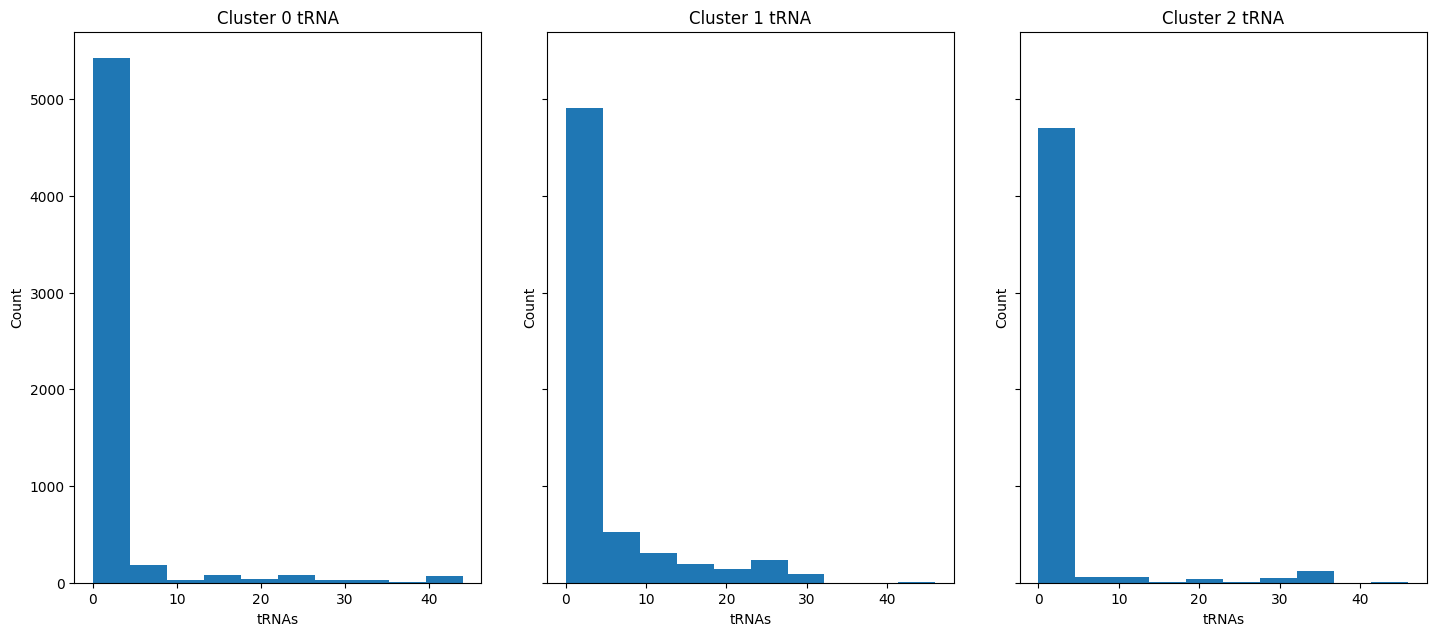

In [84]:
#trna composition across clusters
unique_clusters = sorted(all_meta_data['cluster_label'].unique())
fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)

axes = axes.flatten()

for i, cluster in enumerate(unique_clusters):
    ax = axes[i]

    cluster_data = all_meta_data[all_meta_data['cluster_label'] == cluster]
    ax.hist(cluster_data['tRNAs'], bins=10)
    # sns.displot(cluster_data['tRNAs'], bins=10, ax=ax, color='skyblue')
    ax.set_title(f'Cluster {cluster} tRNA')
    ax.set_xlabel('tRNAs')
    ax.set_ylabel('Count')
plt.tight_layout(pad=3.0)

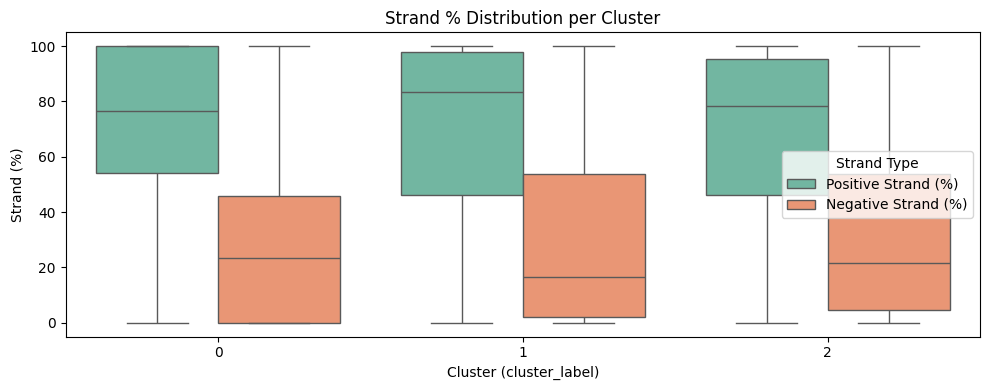

In [85]:
# positive, negative strand composition in clusters

df_long = pd.melt(
    all_meta_data,
    id_vars=['cluster_label'],
    value_vars=['Positive Strand (%)', 'Negative Strand (%)'],
    var_name='Strand Type',
    value_name='Strand (%)'
)
props = dict(marker='o', markersize=6, markerfacecolor='gray', alpha=0.5)
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_long, x='cluster_label', y='Strand (%)', hue='Strand Type', palette='Set2', flierprops=props)

plt.title('Strand % Distribution per Cluster')
plt.xlabel('Cluster (cluster_label)')
plt.legend(title='Strand Type')
plt.tight_layout()
plt.show()


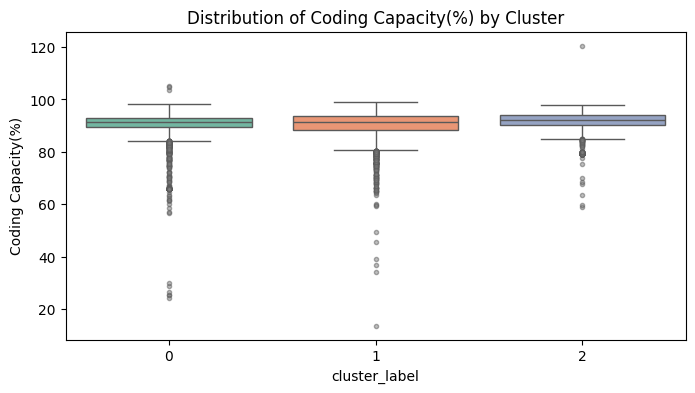

In [86]:
# Coding capacity across clusters

plt.figure(figsize=(8, 4))
flierprops = dict(marker='o', markersize=3, markerfacecolor='gray', alpha=0.5)
sns.boxplot(data=all_meta_data, x='cluster_label', y='Coding Capacity(%)' , palette='Set2', hue = 'cluster_label',legend=False, flierprops=flierprops)
plt.title('Distribution of Coding Capacity(%) by Cluster')
plt.show()



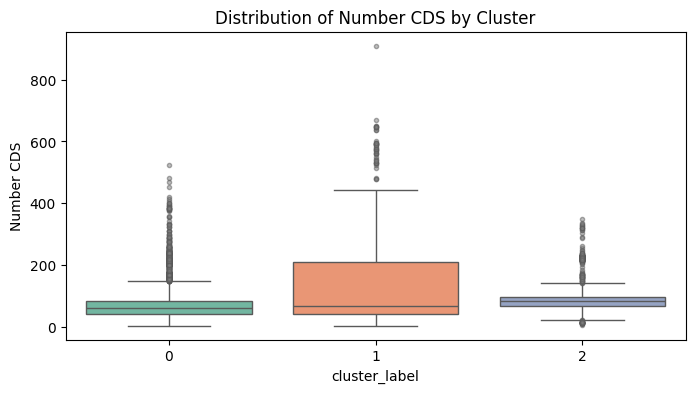

In [87]:
# nuumber of CDS across clusters

plt.figure(figsize=(8, 4))
cds_flierprops = dict(marker='o', markersize=3, markerfacecolor='gray', alpha=0.5)
sns.boxplot(data=all_meta_data, x='cluster_label', y='Number CDS' , palette='Set2', hue = 'cluster_label',legend=False, flierprops=cds_flierprops)
plt.title('Distribution of Number CDS by Cluster')
plt.show()
